<a href="https://colab.research.google.com/github/ffructose/UkrTextRec/blob/main/UkrTextRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ukrainian Handwritten Text Recognition using CRNN

Anna Hnatiuk

# LINE RECOGNITION

## 1. Settings


In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
import random

I have uploaded into a local folder archive with a dataset:
lines/all images in my dataset . zip

In [6]:
!unzip -q /content/lines.zip -d /content/


In [7]:
!ls /content/lines | wc -l


37318


## 2. Paths


In [28]:
# local Data Paths, not on DRIVE (for faster data reading)
BASE_DIR = "/content"

IMAGES_DIR    = os.path.join(BASE_DIR, "lines")
GT_FILE       = os.path.join(BASE_DIR, "METAFILE.tsv")

# alphabet File - contains all unique characters from data metafiles (including space - ' ')
ALPHABET_FILE    = os.path.join(BASE_DIR, "alphabet.txt")

MODEL_DIR = os.path.join(BASE_DIR, "model")


# check whether all needed directories and files exist
required_dirs = [
    IMAGES_DIR,
    MODEL_DIR
]

required_files = [
    GT_FILE,
    ALPHABET_FILE
]



for d in required_dirs:
    if not os.path.isdir(d):
        raise FileNotFoundError(f"NOT FOUND: {d}")
    else:
        print(f"OK {d}")


for f in required_files:
    if not os.path.isfile(f):
        raise FileNotFoundError(f"NOT FOUND{f}")
    else:
        print(f"OK {f}")

BATCH_SIZE    = 32  # model will process 32 samples at a time before updating its weights
EPOCHS        = 50
LEARNING_RATE = 1e-3


# earlystopping params
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "best_model.keras"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

OK /content/lines
OK /content/model
OK /content/METAFILE.tsv
OK /content/alphabet.txt


## 3. Reading data

In [10]:
# 1) Reading metafile
filenames, texts = [], []
with open(GT_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        fname, txt = line.strip().split('\t', 1)
        filenames.append(os.path.normpath(os.path.join(IMAGES_DIR, fname)))
        texts.append(txt)

# 2) Dividing into train / val / test
all_data = list(zip(filenames, texts))

# 1% of data into test
train_val, test = train_test_split(all_data, test_size=0.01, random_state=42)

# 4% of data into val
train, val = train_test_split(train_val, test_size=4/99, random_state=42)

train_filenames, train_texts = zip(*train)
val_filenames, val_texts = zip(*val)
test_filenames, test_texts = zip(*test)

print(f"Loaded data:\n - train: {len(train_filenames)}\n - val: {len(val_filenames)}\n - test: {len(test_filenames)}")


# 3) Reading alphabet file
with open(ALPHABET_FILE, 'r', encoding='utf-8') as f:
    charset = [line.rstrip('\n') for line in f if line.rstrip('\n') != '']


# all characters in alphabet file
print(f"Loaded alphabet: {len(charset)}:")
print(charset)

# mappings for CTC
char_to_num = {ch: i for i, ch in enumerate(charset)}   # 'a'-> 0, 'b'-> 1, 'c'-> 2...
num_to_char = {i: ch for ch, i in char_to_num.items()}  # 0-> 'a', 1-> 'b', 2-> 'c'...

BLANK_IDX   = len(charset)        # blank token, used internally by CTC
NUM_CLASSES = len(charset) + 1    # +1 class for blank

print(f"Amount of classes: \n {NUM_CLASSES} ({len(charset)} characters + blank token)")


Loaded data:
 - train: 35451
 - val: 1493
 - test: 374
Loaded alphabet: 102:
[' ', '!', '"', '%', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'B', 'I', 'O', 'Q', 'S', 'V', 'X', 'a', 'c', 'e', 'g', 'i', 'l', 'n', 'p', 'r', 'u', 'Є', 'І', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я', 'є', 'і', 'ї', 'ґ']
Amount of classes: 
 103 (102 characters + blank token)


## 4. Setting height and width


As in my dataset, all images have different height and width - we are looking for the maximum height and maximum width, so that later I can decide what height would be optimal

In [11]:
# combining train, val and test metafiles into one metafile
all_filenames = train_filenames + val_filenames + test_filenames

print(f"Images to check: {len(all_filenames)}")

heights = []
widths = []
failed_paths = []

for path in all_filenames:
    try:
        img = Image.open(path).convert('L')
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except Exception as e:
        failed_paths.append((path, str(e)))

# Searching for Errors
if failed_paths:
    print(f"\n{len(failed_paths)} img failed to open:")
    for i, (p, err) in enumerate(failed_paths[:5]):  # first 5
        print(f"   {i+1}. {p} — {err}")
    raise RuntimeError("CANNOT OPEN")

# maximum height
max_H = max(heights)

# maximum width (round it up to a multiple of 4)
max_W = ((max(widths) + 3) // 4) * 4


print(f"Maximum height (max_H): {max_H}")
print(f"Maximum width (max_W): {max_W}")


Images to check: 37318
Maximum height (max_H): 242
Maximum width (max_W): 1756


## 5. Preprocessing

In [12]:
TARGET_HEIGHT = 128  # it is optimal


# loading image from dir, padding it to the max height and max width and normalizing
def preprocess_image(path):
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode('utf-8')
    elif isinstance(path, (bytes, bytearray)):
        path = path.decode('utf-8')
    else:
        path = str(path)

    img = Image.open(path).convert('L')
    w, h = img.size

    new_w = int((w / h) * TARGET_HEIGHT)
    img = img.resize((new_w, TARGET_HEIGHT), Image.BILINEAR)

    arr = np.array(img, dtype=np.float32) / 255.0
    arr = (arr - 0.5) * 2.0
    arr = arr[..., np.newaxis]

    return arr

# encoding a string into a list of integer indices (based on alphabet),
# so it can be used in training with CTC loss.
def encode_label(txt):
    if isinstance(txt, tf.Tensor):  #Ensures that txt is a plain Python string
        s = txt.numpy().decode('utf-8')
    elif isinstance(txt, (bytes, bytearray)):
        s = txt.decode('utf-8')
    else:
        s = str(txt)

    # build the label array, skipping any unknown chars
    labels = []
    for c in s:
        if c in char_to_num:
            labels.append(char_to_num[c])
        else:
            continue

    return np.array(labels, dtype=np.int32)

# augmentation makes data worse, for model resistance
def augment_image(image):
    if image.shape[-1] != 1:
        image = tf.expand_dims(image, axis=-1)

    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.08)
    image = image + noise

    def blur(img):
        kernel = tf.constant([[1., 2., 1.],
                              [2., 4., 2.],
                              [1., 2., 1.]], dtype=tf.float32)
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.reshape(kernel, [3, 3, 1, 1])
        img = tf.nn.conv2d(tf.expand_dims(img, 0), kernel, [1, 1, 1, 1], padding='SAME')
        return tf.squeeze(img, 0)

    if tf.random.uniform([]) < 0.5:
        image = blur(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

# prepares a single training sample
def tf_preprocess_train(path, txt):
    # loading image
    img = tf.py_function(preprocess_image, inp=[path], Tout=tf.float32)
    img.set_shape([TARGET_HEIGHT, None, 1])  # None — width is variable


    # 20% of data goes through augmentation
    do_augment = tf.less(tf.random.uniform([]), 0.2)  # True in ~20% cases
    img = tf.cond(do_augment, lambda: augment_image(img), lambda: img)


    # encoding the label
    lbl = tf.py_function(encode_label, inp=[txt], Tout=tf.int32)
    lbl.set_shape([None])

    # computing lenghts for CTC loss
    input_len = compute_input_len(img)
    label_len = tf.shape(lbl)[0]

    return {
        'img': img,
        'label': lbl,
        'input_len': input_len,
        'label_len': label_len
    }


def tf_preprocess_plain(path, txt):
    img = tf.py_function(preprocess_image, inp=[path], Tout=tf.float32)
    img.set_shape([TARGET_HEIGHT, None, 1])

    lbl = tf.py_function(encode_label, inp=[txt], Tout=tf.int32)
    lbl.set_shape([None])

    input_len = compute_input_len(img)
    label_len = tf.shape(lbl)[0]

    return {
        'img': img,
        'label': lbl,
        'input_len': input_len,
        'label_len': label_len
    }

testing augmentation

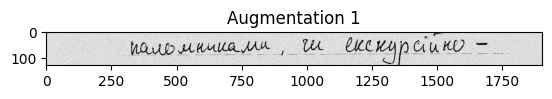

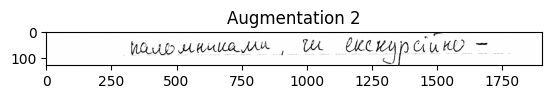

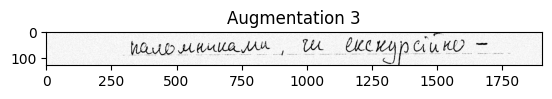

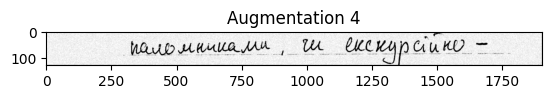

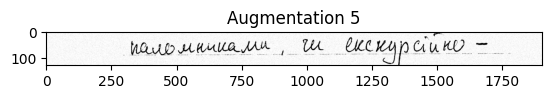

In [13]:
import tensorflow as tf
import numpy as np

def force_augment_image(image):
    if image.shape[-1] != 1:
        image = tf.expand_dims(image, axis=-1)

    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.08)
    image = image + noise

    def blur(img):
        kernel = tf.constant([[1., 2., 1.],
                              [2., 4., 2.],
                              [1., 2., 1.]], dtype=tf.float32)
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.reshape(kernel, [3, 3, 1, 1])
        img = tf.nn.conv2d(tf.expand_dims(img, 0), kernel, [1, 1, 1, 1], padding='SAME')
        return tf.squeeze(img, 0)

    if tf.random.uniform([]) < 0.5:
        image = blur(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

img_path = "/content/lines/a01-001-0023-03.png"

preprocessed = preprocess_image(img_path)
tensor = tf.convert_to_tensor(preprocessed, dtype=tf.float32)

augmented = force_augment_image(tensor)
for i in range(5):
    tf.random.set_seed(i)
    aug = force_augment_image(tensor)

    plt.imshow(aug[..., 0], cmap='gray')
    plt.title(f"Augmentation {i+1}")
    plt.show()

## 6. Datasets (train, test, val)

In [14]:
print(type(train_filenames), len(train_filenames))
print(type(train_texts), len(train_texts))


<class 'tuple'> 35451
<class 'tuple'> 35451


In [29]:
def compute_input_len(img):
    return tf.shape(img)[1] // 4


# turning lists of image paths and texts into a ready-to-train tf.data.Dataset pipeline
def make_dataset(paths, texts, preprocess_fn, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, texts))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.padded_batch(
        BATCH_SIZE,
        padded_shapes={
            'img': [TARGET_HEIGHT, None, 1],  # adaptive width
            'label': [None],
            'input_len': [],
            'label_len': []
        },
        padding_values={
            'img': tf.constant(1.0, dtype=tf.float32),
            'label': tf.constant(-1, dtype=tf.int32),
            'input_len': tf.constant(0, dtype=tf.int32),
            'label_len': tf.constant(0, dtype=tf.int32)
        }
    )

    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(list(train_filenames), list(train_texts), preprocess_fn=tf_preprocess_train, shuffle=True)
val_ds   = make_dataset(list(val_filenames),   list(val_texts),   preprocess_fn=tf_preprocess_plain, shuffle=False)
test_ds  = make_dataset(list(test_filenames),  list(test_texts),  preprocess_fn=tf_preprocess_plain, shuffle=False)



In [24]:
print("Train samples:", len(train_filenames))
print("Val samples:",   len(val_filenames))
print("Test samples:",  len(test_filenames))


Train samples: 35451
Val samples: 1493
Test samples: 374


## 7. CER WER Evaluation

In [25]:
# distance between two sequences (characters or words)
def levenshtein(a, b):
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n

    # distance matrix
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n+1): dp[i][0] = i
    for j in range(m+1): dp[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(
                dp[i-1][j] + 1,      # deletion
                dp[i][j-1] + 1,      # insertion
                dp[i-1][j-1] + cost  # substitution
            )
    return dp[n][m]

# measures how many characters are wrong in the prediction
def cer(ref, hyp):
    ref_chars = list(ref)
    hyp_chars = list(hyp)
    if len(ref_chars) == 0:
        return float(len(hyp_chars))
    return levenshtein(ref_chars, hyp_chars) / len(ref_chars)

# measures how many words are wrong in the prediction
def wer(ref, hyp):
    ref_words = ref.split()
    hyp_words = hyp.split()
    if len(ref_words) == 0:
        return float(len(hyp_words))
    return levenshtein(ref_words, hyp_words) / len(ref_words)

# cer wer for a batch of predictions
def calculate_cer_wer_py(decoded_preds, gt_labels):
    total_cer, total_wer = 0.0, 0.0
    batch_size = len(decoded_preds)

    if batch_size == 0:
        return 0.0, 0.0

    for i in range(batch_size):
        # tensor into python-sequence
        pred_str = decoded_preds[i].numpy().decode('utf-8')
        gt_str = gt_labels[i].numpy().decode('utf-8')

        total_cer += cer(gt_str, pred_str)
        total_wer += wer(gt_str, pred_str)

    return total_cer / batch_size, total_wer / batch_size


## 8. Model architecture

CRNN (Convolutional Recurrent Neural Network) model for handwriting recognition, using TensorFlow + Keras.

In [30]:
class CRNNWithLoss(tf.keras.Model):
    def __init__(self, num_classes, char_to_num, num_to_char):
        super().__init__()
        self.num_classes = num_classes
        self.char_to_num = char_to_num
        self.num_to_char = num_to_char
        self.blank_idx = len(char_to_num)  # index used for CTC blank token

        # defines CNN feature extractor (convolutional layers)
        input_img = layers.Input(shape=(TARGET_HEIGHT, None, 1), name='img')
        x = input_img

        # 5 convolutional layers with ReLU activation
        # 5 max pooling layers to downsample
        for i, (filters, pool_size) in enumerate(zip(
            [16, 32, 64, 128, 128],
            [(2, 2), (2, 2), (2, 1), (2, 1), (2, 1)]
        )):
            x = layers.Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
            x = layers.MaxPooling2D(pool_size)(x)
        # width is downsampled by a factor of 4 (from 2x2 and 2x1 poolings),
        # height is reduced more aggressively (by factor of 32).


        # Rreshape to sequence: (batch, width, height * channels)
        x = layers.Permute((2, 1, 3))(x)  # Reorder to (batch, width, height, channels)
        x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)
        # x = (batch, time_steps, features)

        # 2 bidirectional LSTM layers
        # each time step is now contextualized using information from left and right
        x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
        x = layers.Dropout(0.25)(x)
        # this allows  model to understand character dependencies in both directions


        # final dense layer with softmax for character classification
        # gives a probability distribution over characters for each time step
        y_pred = layers.Dense(self.num_classes, activation='softmax', name='y_pred')(x)

        self.crnn = tf.keras.Model(inputs=input_img, outputs=y_pred)

        # trackers for loss and evaluation metrics
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.cer_tracker = tf.keras.metrics.Mean(name="cer")
        self.wer_tracker = tf.keras.metrics.Mean(name="wer")

    def call(self, inputs):
        return self.crnn(inputs)

    @property
    def metrics(self):
        # Return list of metrics for tracking
        return [self.loss_tracker, self.cer_tracker, self.wer_tracker]

    def decode_labels(self, encoded):

        # converts encoded sequences back to strings using num_to_char mapping.
        # supports both RaggedTensor and standard Tensor inputs.
        if isinstance(encoded, tf.RaggedTensor):
            return tf.strings.reduce_join(
                tf.nn.embedding_lookup(
                    tf.constant(list(self.num_to_char.values()), dtype=tf.string),
                    encoded
                ),
                axis=-1
            )
        else:
            filtered = tf.ragged.boolean_mask(encoded, tf.not_equal(encoded, -1))
            return tf.strings.reduce_join(
                tf.nn.embedding_lookup(
                    tf.constant(list(self.num_to_char.values()), dtype=tf.string),
                    filtered
                ),
                axis=-1
            )


# @tf.function - > decorator that compiles the function into a fast TensorFlow graph

    @tf.function(reduce_retracing=True)
    def train_step(self, data): # training model on one batch of data
        imgs = data['img']
        labels = data['label']
        input_len = data['input_len']
        label_len = data['label_len']

        with tf.GradientTape() as tape:

            # model’s output probabilities over time
            y_pred = self.crnn(imgs, training=True) # (batch, T, num_classes)

            # compute CTC loss (per-batch)
            loss = tf.reduce_mean(tf.keras.backend.ctc_batch_cost(
                labels,
                y_pred,
                tf.expand_dims(input_len, -1),
                tf.expand_dims(label_len, -1)
            ))#  averages loss over the batch

        # computes gradients of the loss with respect to model weights
        grads = tape.gradient(loss, self.crnn.trainable_variables)

        # updates weights using the optimizer (Adam)
        self.optimizer.apply_gradients(zip(grads, self.crnn.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @tf.function(reduce_retracing=True)
    def test_step(self, data):
        imgs = data['img']
        labels = data['label']
        input_len = data['input_len']
        label_len = data['label_len']

        y_pred = self.crnn(imgs, training=False)

        loss = tf.reduce_mean(tf.keras.backend.ctc_batch_cost(
            labels,
            y_pred,
            tf.expand_dims(input_len, -1),
            tf.expand_dims(label_len, -1)
        ))

        decoded_dense, _ = tf.keras.backend.ctc_decode(
            y_pred,
            input_length=input_len,
            greedy=True
        )
        decoded_strings = self.decode_labels(decoded_dense[0])
        gt_strings = self.decode_labels(labels)

        cer_val, wer_val = tf.py_function(
            calculate_cer_wer_py,
            inp=[decoded_strings, gt_strings],
            Tout=[tf.float64, tf.float64]
        )

        cer_val.set_shape(())
        wer_val.set_shape(())

        self.loss_tracker.update_state(loss)
        self.cer_tracker.update_state(cer_val)
        self.wer_tracker.update_state(wer_val)

        return {m.name: m.result() for m in self.metrics}


## 9. Training - MAIN

In [31]:
# create model instance
model = CRNNWithLoss(
    num_classes=NUM_CLASSES,
    char_to_num=char_to_num,
    num_to_char=num_to_char
)

# Perform a warm-up forward pass to initialize model variables
dummy_input = tf.random.uniform([1, TARGET_HEIGHT, 400, 1], dtype=tf.float32)
_ = model(dummy_input)

# compiling  model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    run_eagerly=False
)

# starting training
history = model.fit(
    train_ds,                     # training dataset
    validation_data=val_ds,       # validation dataset
    epochs=EPOCHS,                # total number of training epochs
    callbacks=[checkpoint_cb, earlystop_cb]  # callbacks to save best model and stop early if no improvement
)


Epoch 1/50
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - loss: 108.7507
Epoch 1: val_loss improved from inf to 26.70979, saving model to /content/model/best_model.keras
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 1096s 983ms/step - loss: 108.7185 - val_cer: 0.2717 - val_loss: 26.7098 - val_wer: 0.7844
Epoch 2/50
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 21.1157
Epoch 2: val_loss improved from 26.70979 to 12.30841, saving model to /content/model/best_model.keras
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 423s 381ms/step - loss: 21.1127 - val_cer: 0.1208 - val_loss: 12.3084 - val_wer: 0.4987
Epoch 3/50
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 11.8084
Epoch 3: val_loss improved from 12.30841 to 9.67843, saving model to /content/model/best_model.keras
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 388s 350ms/step - loss: 11.8078 - val_cer: 0.0976 - val_loss: 9.6784 - val_wer: 0.4269
Epoch 4/50
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 9.0095
Epoch 4: val_loss improved from 9.67843 to 7.91883, sa

## 10. Statistics

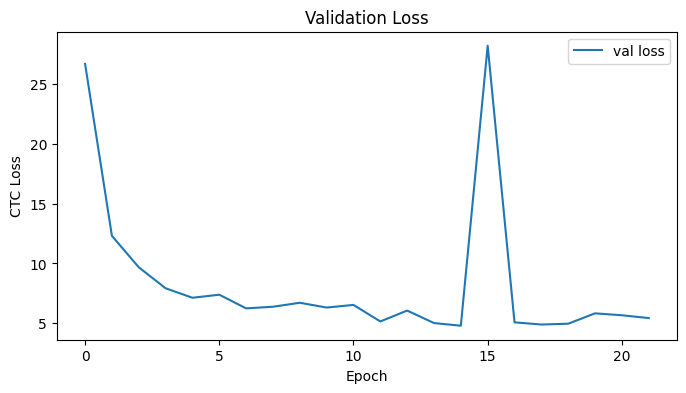

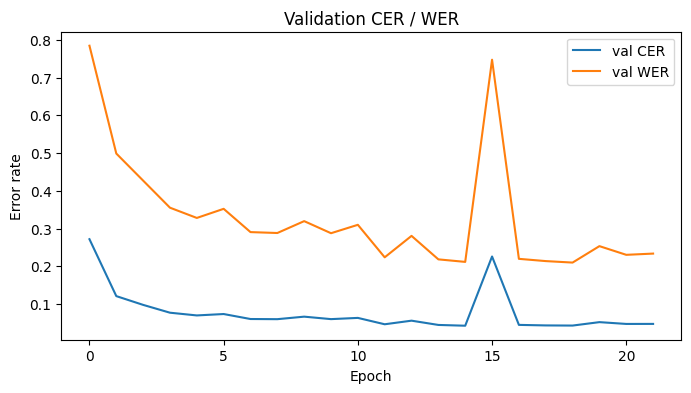

In [32]:
# only validation stats (those are tracked automatically)
plt.figure(figsize=(8,4))
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['val_cer'], label='val CER')
plt.plot(history.history['val_wer'], label='val WER')
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.title('Validation CER / WER')
plt.legend()
plt.show()


## 11. Testing Results (output)

In [33]:
#only if you have already a trained model
#model = load_model(os.path.join(MODEL_DIR, "best_model1.keras"))

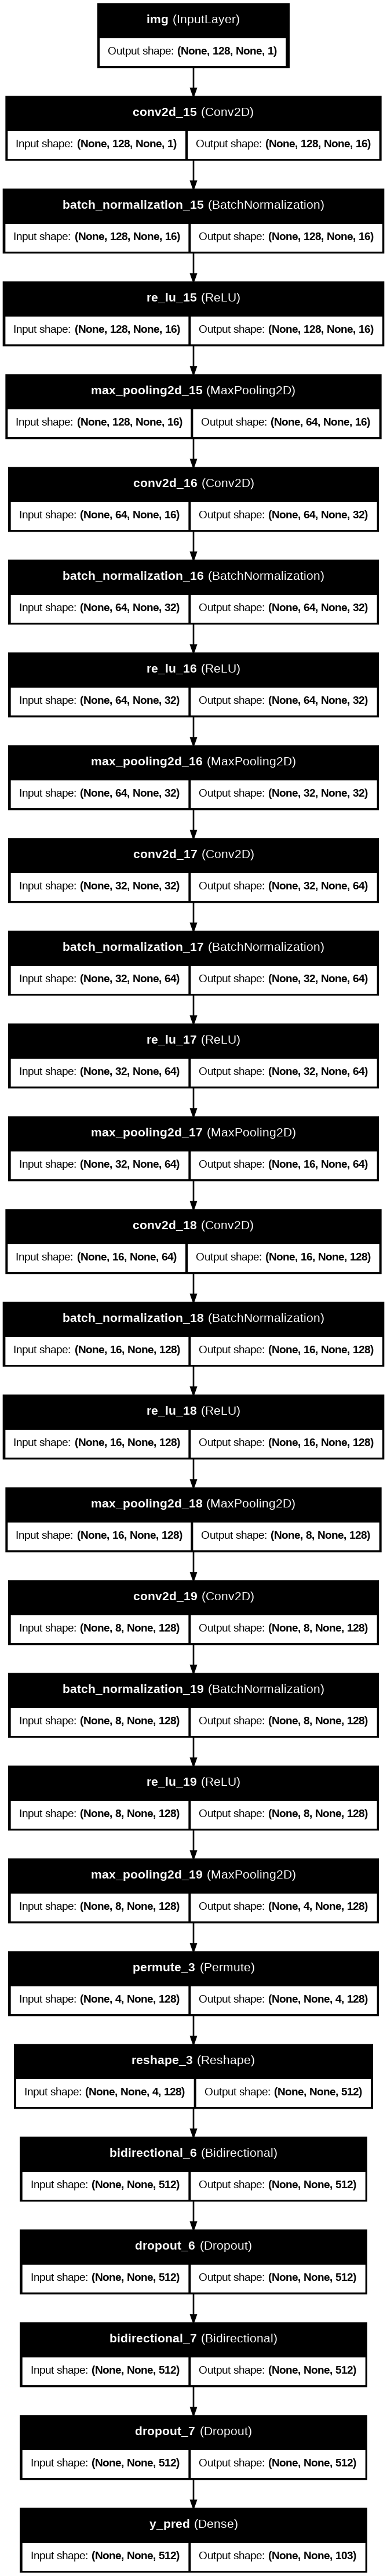

In [34]:
plot_model(model.crnn, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=96)

In [35]:
model = CRNNWithLoss(
    num_classes=NUM_CLASSES,
    char_to_num=char_to_num,
    num_to_char=num_to_char
)

model.crnn.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 128, None, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, None, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128, None, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 128, None, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, None, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, None, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64, None, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 64, None, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, None, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, None, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, None, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 32, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, None, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, None, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 16, None, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, None, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, None, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, None, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 8, None, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 4, None, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_4 (Permute)             │ (None, None, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,448,871 (13.16 MB)

 Trainable params: 3,448,135 (13.15 MB)

 Non-trainable params: 736 (2.88 KB)

In [50]:
def predict_image(model, image_path):
    img = tf.py_function(preprocess_image, inp=[image_path], Tout=tf.float32)
    img.set_shape([TARGET_HEIGHT, None, 1])
    img = tf.expand_dims(img, 0)

    pred = model(img, training=False)
    input_len = tf.shape(pred)[1]

    decoded, _ = tf.keras.backend.ctc_decode(pred, input_length=[input_len], greedy=True)
    pred_text = model.decode_labels(decoded[0]).numpy()[0].decode('utf-8')

    return pred_text

In [51]:
def predict_many_images(model, image_paths, gt_texts, amount=5, seed=42):
    random.seed(seed)

    indices = random.sample(range(len(image_paths)), min(amount, len(image_paths)))

    total_cer = 0.0
    total_wer = 0.0

    print(f"Evaluating {len(indices)} randomly selected images...\n")

    for idx in indices:
        path = image_paths[idx]
        gt = gt_texts[idx]

        pred = predict_image(model, path)

        cur_cer = cer(gt, pred)
        cur_wer = wer(gt, pred)

        total_cer += cur_cer
        total_wer += cur_wer

        print(f"  File: {os.path.basename(path)}")
        print(f"  GT:   {gt}")
        print(f"  Pred: {pred}")
        print(f"  CER:  {cur_cer:.4f}")
        print(f"  WER:  {cur_wer:.4f}\n")

    avg_cer = total_cer / len(indices)
    avg_wer = total_wer / len(indices)

    print(f"Avg CER over {len(indices)} samples: {avg_cer:.4f}")
    print(f"Avg WER over {len(indices)} samples: {avg_wer:.4f}")

In [52]:
predict_many_images(model, test_filenames, test_texts, amount=5)


Evaluating 5 randomly selected images...

  File: a01-009-0067-05.png
  GT:   впливає як на фізичний, так
  Pred: впливає як на фізичний, тас
  CER:  0.0370
  WER:  0.2000

  File: a01-034-0112-02.png
  GT:   Подільської височини є
  Pred: Подільської вчсочини є
  CER:  0.0455
  WER:  0.3333

  File: a01-078-0071-13.png
  GT:   пояснення.
  Pred: пояснення.
  CER:  0.0000
  WER:  0.0000

  File: a01-180-0032-02.png
  GT:   тобі колись дуже подобалася, відчуваєш ніби маленьке
  Pred: тобі колись дуже подобалася, відчуваєш ніби маленьке
  CER:  0.0000
  WER:  0.0000

  File: a01-009-0175-03.png
  GT:   "велосипед", на кшталт польської
  Pred: "велоситеді, на кштат польської
  CER:  0.0938
  WER:  0.5000

Avg CER over 5 samples: 0.0352
Avg WER over 5 samples: 0.2067
